In [2]:
# Imports
import os
import random
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
print("TensorFlow version:", tf.__version__)

C:\jupyter\venv\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
C:\jupyter\venv\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
C:\jupyter\venv\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/resource_handle.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  

TensorFlow version: 2.20.0


In [3]:
# Load dataset
df = pd.read_csv('reddit_preprocessing.csv').dropna(subset=['clean_comment'])

# Ensure labels are integer
df['category'] = df['category'].astype(int)

# Train-test split
X_train_text, X_test_text, y_train, y_test = train_test_split(
    df['clean_comment'],
    df['category'],
    test_size=0.2,
    random_state=SEED,
    stratify=df['category']
)

# Tokenize + Pad
MAX_WORDS = 50000
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_text.tolist())

X_train_seq = tokenizer.texts_to_sequences(X_train_text.tolist())
X_test_seq  = tokenizer.texts_to_sequences(X_test_text.tolist())

# Determine max_len
lengths = np.array([len(x) for x in X_train_seq])
max_len = int(min(300, np.percentile(lengths[lengths > 0], 95))) if (lengths > 0).any() else 50
max_len = max(max_len, 20)
print(f"Chosen max_len = {max_len}")

# Pad sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad  = pad_sequences(X_test_seq,  maxlen=max_len, padding='post', truncating='post')

# Class weights
classes = np.array([0, 1])
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train.values)
class_weight_dict = {int(c): w for c, w in zip(classes, class_weights)}
class_weight_dict

Chosen max_len = 300


{0: np.float64(1.0015584154433943), 1: np.float64(0.9984464267815977)}

In [59]:
def build_lstm_model(vocab_size=MAX_WORDS, max_len=max_len, embedding_dim=64, lstm_units=32, dropout_rate=0.5, lr=1e-3):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim))
    model.add(Bidirectional(LSTM(lstm_units, dropout=dropout_rate, recurrent_dropout=0.1)))
    model.add(Dense(32, activation='relu'))


    model.add(Dense(1, activation='sigmoid'))  # binary classification output

    optimizer = Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = build_lstm_model()
model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_13 (Embedding)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_13 (Bidirectional)     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_36 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_37 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [60]:
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-5, verbose=1)
]

In [61]:
history = model.fit(
    X_train_pad, y_train.values,
    validation_split=0.15,
    epochs=10,           # CPU-friendly
    batch_size=32,       # CPU-friendly
    class_weight=class_weight_dict,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/10
530/530 ━━━━━━━━━━━━━━━━━━━━ 293s 520ms/step - accuracy: 0.7784 - loss: 0.4657 - val_accuracy: 0.8655 - val_loss: 0.3393 - learning_rate: 0.0010
Epoch 2/10
530/530 ━━━━━━━━━━━━━━━━━━━━ 286s 540ms/step - accuracy: 0.8992 - loss: 0.2655 - val_accuracy: 0.8618 - val_loss: 0.3445 - learning_rate: 0.0010
Epoch 3/10
530/530 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - accuracy: 0.9327 - loss: 0.1926  
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
530/530 ━━━━━━━━━━━━━━━━━━━━ 310s 517ms/step - accuracy: 0.9383 - loss: 0.1782 - val_accuracy: 0.8498 - val_loss: 0.3692 - learning_rate: 0.0010
Epoch 4/10
530/530 ━━━━━━━━━━━━━━━━━━━━ 263s 496ms/step - accuracy: 0.9647 - loss: 0.1036 - val_accuracy: 0.8672 - val_loss: 0.4325 - learning_rate: 5.0000e-04
Epoch 5/10
530/530 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step - accuracy: 0.9771 - loss: 0.0730  
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
530/530 ━━━━━━━━━━━━━━━━━━━━ 259s 488ms/step - accu

156/156 ━━━━━━━━━━━━━━━━━━━━ 14s 80ms/step
Accuracy: 0.8755
Precision: 0.8951
Recall: 0.8513
F1-score: 0.8726


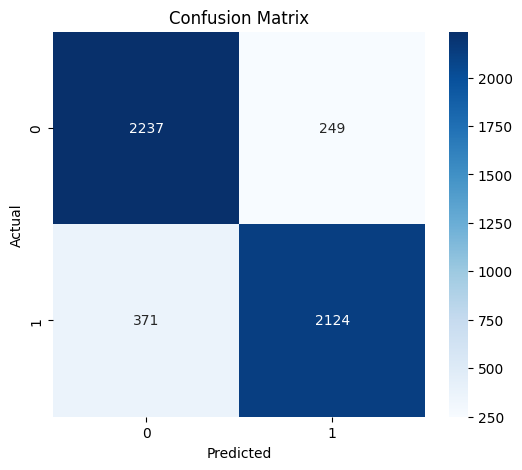

In [62]:
# Evaluate

# Predictions
y_pred_prob = model.predict(X_test_pad, batch_size=32)
y_pred = (y_pred_prob >= 0.5).astype(int).ravel()

# Metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-score: {f1:.4f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [7]:
import pickle

# Save tokenizer
with open('lstm_tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

# Load tokenizer
with open('lstm_tokenizer.pkl', 'rb') as f:
    lstm_tokenizer = pickle.load(f)